# 1. Import Dependencies

In [66]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable 

from neuralprophet import NeuralProphet

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdate
import seaborn as sns

import pandas as pd
import datetime as dt
import requests

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr as PCC

from neural_network_classes import LSTM, DARNN

print("All libraries loaded")

All libraries loaded


# 2. Download Data

In [2]:
def download_data(url, name='', usecols=None, sheet_name=1, header=2, plot=False): 
    global config
    
    r = requests.get(url)
    open('temp.xls', 'wb').write(r.content)
    df = pd.read_excel('temp.xls', sheet_name=sheet_name, header=header, usecols=usecols) 
    df = df[~df.isnull().any(axis=1)] # remove rows with any missing data
       
    num_data_points = len(df)
    
    df2 = df.iloc[[0, -1]]    
    date_range = "from " + str(df2.iloc[0,0]) + " to " + str(df2.iloc[1,0])
    print(date_range, str(num_data_points) + ' Data Points')
    
    data_dict = {}
    data_dict['data'] = df.rename(columns={df.keys()[0]: 'date', 
                            df.keys()[1]: name})
    data_dict['num elements'] = num_data_points
    data_dict['date range'] = date_range
    data_dict['name'] = df.keys()[1]
    
    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_dict['data']['date'], data_dict['data'][name], color=config["plots"]["color_actual"])
        plt.title(data_dict['name'] + ", " + data_dict['date range'] + ", " + str(data_dict['num elements']) + " Data Points")

        # Format the x axis
        locator = mdate.MonthLocator(interval=config["plots"]["xticks_interval"])
        fmt = mdate.DateFormatter('%Y-%m')
        X = plt.gca().xaxis
        X.set_major_locator(locator)
        # Specify formatter
        X.set_major_formatter(fmt)
        plt.xticks(rotation='vertical')
        plt.xlim([data_dict['data'].iloc[0,0], data_dict['data'].iloc[-1,0]])

        plt.grid(visible=None, which='major', axis='y', linestyle='--')
        plt.show()
         
    return data_dict

In [3]:
plot = False

## 2a. Seattle Gas Prices (targets)

In [4]:
seattle_gas_prices = download_data('https://www.eia.gov/dnav/pet/hist_xls/EMM_EPMRU_PTE_Y48SE_DPGw.xls', 
                                   name='gas price',
                                  plot=plot)

print(seattle_gas_prices['data'].head())

from 2003-05-26 00:00:00 to 2022-07-11 00:00:00 999 Data Points
        date  gas price
0 2003-05-26      1.534
1 2003-06-02      1.524
2 2003-06-09      1.522
3 2003-06-16      1.578
4 2003-06-23      1.580


## 2b. U.S. Crude Oil Stock Change (feature 1)

In [5]:
us_oil_stock = download_data('https://www.eia.gov/dnav/pet/hist_xls/MCRSCUS1m.xls',
                             name='oil stock exchange',
                             plot=plot)

print(us_oil_stock['data'].head())

from 1981-01-15 00:00:00 to 2022-04-15 00:00:00 496 Data Points
        date  oil stock exchange
0 1981-01-15               -1535
1 1981-02-15                7773
2 1981-03-15               19596
3 1981-04-15               17853
4 1981-05-15               12109


## 2c. U.S. Natural Gas Rotary Rigs in Operation (feature 2)

In [6]:
us_drilling_activity = download_data('https://www.eia.gov/dnav/pet/hist_xls/E_ERTRRG_XR0_NUS_Cm.xls',
                             name='drilling activity',
                             plot=plot)

print(us_drilling_activity['data'].head())

from 1987-08-15 00:00:00 to 2022-03-15 00:00:00 416 Data Points
          date  drilling activity
175 1987-08-15              352.0
176 1987-09-15              364.0
177 1987-10-15              377.0
178 1987-11-15              386.0
179 1987-12-15              403.0


## 2d. U.S. Natural Gas Production (feature 3)

In [7]:
us_gas_production = download_data('https://www.eia.gov/dnav/ng/hist_xls/N9050US2m.xls',
                             name='gas production',
                             plot=plot)

print(us_gas_production['data'].head())

from 1973-01-15 00:00:00 to 2022-04-15 00:00:00 592 Data Points
        date  gas production
0 1973-01-15         1948000
1 1973-02-15         1962000
2 1973-03-15         1907000
3 1973-04-15         1814000
4 1973-05-15         1898000


## 2e. U.S. Natural Gas Consumption (feature 4)

In [8]:
us_gas_consumption = download_data('https://www.eia.gov/dnav/ng/hist_xls/N9140US2m.xls',
                             name='gas consumption',
                             plot=plot)

print(us_gas_consumption['data'].head())

from 2001-01-15 00:00:00 to 2022-04-15 00:00:00 256 Data Points
        date  gas consumption
0 2001-01-15          2676998
1 2001-02-15          2309464
2 2001-03-15          2246633
3 2001-04-15          1807170
4 2001-05-15          1522382


## 2f. Underground Natural Gas Storage Capacity (feature 5)

In [9]:
us_gas_storage = download_data('https://www.eia.gov/dnav/ng/xls/NG_STOR_CAP_DCU_NUS_M.xls',
                             name='gas storage',
                               usecols='A:B',
                             plot=plot)

print(us_gas_storage['data'].head())

from 1989-01-15 00:00:00 to 2022-04-15 00:00:00 400 Data Points
        date  gas storage
0 1989-01-15      8119368
1 1989-02-15      8119368
2 1989-03-15      8119368
3 1989-04-15      8119368
4 1989-05-15      8119368


## 2g. U.S. Natural Gas Import Volumes (feature 6)

In [10]:
us_gas_import_volume = download_data('https://www.eia.gov/dnav/ng/xls/NG_MOVE_IMPC_S1_M.xls',
                             name='gas import volume',
                               usecols='A:B',
                               sheet_name=1,
                             plot=plot)

print(us_gas_import_volume['data'].tail())

from 1973-01-15 00:00:00 to 2022-04-15 00:00:00 592 Data Points
          date  gas import volume
587 2021-12-15             252626
588 2022-01-15             296179
589 2022-02-15             259389
590 2022-03-15             260642
591 2022-04-15             246576


## 2g. U.S. Natural Gas Import Prices (feature 7)

In [11]:
us_gas_import_price = download_data('https://www.eia.gov/dnav/ng/xls/NG_MOVE_IMPC_S1_M.xls',
                             name='gas import price',
                               usecols='A:B',
                               sheet_name=2,
                             plot=plot)

print(us_gas_import_price['data'].tail())

from 1989-01-15 00:00:00 to 2022-04-15 00:00:00 400 Data Points
          date  gas import price
395 2021-12-15              4.74
396 2022-01-15              6.87
397 2022-02-15              5.62
398 2022-03-15              4.67
399 2022-04-15              5.46


## 2h. Henry Hub Natural Gas Spot Price (feature 8)

In [12]:
hh_natural_gas_price = download_data('https://www.eia.gov/dnav/ng/hist_xls/RNGWHHDm.xls',
                             name='natural gas price',
                             plot=plot)

print(hh_natural_gas_price['data'].head())

from 1997-01-15 00:00:00 to 2022-06-15 00:00:00 306 Data Points
        date  natural gas price
0 1997-01-15               3.45
1 1997-02-15               2.15
2 1997-03-15               1.89
3 1997-04-15               2.03
4 1997-05-15               2.25


## 2i. Crude Oil Sport Price (feature 9)

In [13]:
us_crude_oil_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='crude oil price',
                                   usecols='A:B',
                                   sheet_name=1, 
                                   plot=plot)

print(us_crude_oil_price['data'].head())

from 1986-01-15 00:00:00 to 2022-06-15 00:00:00 438 Data Points
        date  crude oil price
0 1986-01-15            22.93
1 1986-02-15            15.46
2 1986-03-15            12.61
3 1986-04-15            12.84
4 1986-05-15            15.38


## 2j. Conventional Gasoline Price (feature 10)

In [14]:
us_gas_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='conventional gas price',
                                   usecols='A:B',
                                   sheet_name=2, 
                                   plot=plot)

print(us_gas_price['data'].head())

from 1986-06-15 00:00:00 to 2022-06-15 00:00:00 433 Data Points
        date  conventional gas price
0 1986-06-15                   0.420
1 1986-07-15                   0.340
2 1986-08-15                   0.426
3 1986-09-15                   0.420
4 1986-10-15                   0.410


## 2k. RBOB Gasoline Price (feature 11)

In [15]:
us_rbob_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='rbob gas price',
                                   usecols='A:B',
                                   sheet_name=3, 
                                   plot=plot)

print(us_rbob_price['data'].head())

from 2003-06-15 00:00:00 to 2022-06-15 00:00:00 229 Data Points
        date  rbob gas price
0 2003-06-15           1.072
1 2003-07-15           0.965
2 2003-08-15           1.315
3 2003-09-15           0.949
4 2003-10-15           0.996


## 2l. Heating Oil Price (feature 12)

In [16]:
us_heating_oil_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='heating oil price',
                                   usecols='A:B',
                                   sheet_name=4, 
                                   plot=plot)

print(us_heating_oil_price['data'].head())

from 1986-06-15 00:00:00 to 2022-06-15 00:00:00 433 Data Points
        date  heating oil price
0 1986-06-15              0.380
1 1986-07-15              0.334
2 1986-08-15              0.408
3 1986-09-15              0.402
4 1986-10-15              0.394


## 2m. Diesel Price (feature 13)

In [17]:
us_diesel_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='diesel price',
                                   usecols='A:B',
                                   sheet_name=5, 
                                   plot=plot)

print(us_diesel_price['data'].head())

from 2006-06-15 00:00:00 to 2022-06-15 00:00:00 193 Data Points
          date  diesel price
122 2006-06-15         2.091
123 2006-07-15         2.217
124 2006-08-15         2.247
125 2006-09-15         1.810
126 2006-10-15         1.794


## 2n. Kerosene Price (feature 14)

In [18]:
us_kerosene_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='kerosene price',
                                   usecols='A:B',
                                   sheet_name=6, 
                                   plot=plot)

print(us_kerosene_price['data'].tail())

from 1990-04-15 00:00:00 to 2022-06-15 00:00:00 387 Data Points
          date  kerosene price
382 2022-02-15           2.682
383 2022-03-15           3.495
384 2022-04-15           3.914
385 2022-05-15           3.902
386 2022-06-15           4.120


## 2o. Propane Price (feature 15)

In [19]:
us_propane_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='propane price',
                                   usecols='A:B',
                                   sheet_name=7, 
                                   plot=plot)

print(us_propane_price['data'].tail())

from 1992-06-15 00:00:00 to 2022-06-15 00:00:00 361 Data Points
          date  propane price
356 2022-02-15          1.283
357 2022-03-15          1.448
358 2022-04-15          1.302
359 2022-05-15          1.223
360 2022-06-15          1.219


# 3. Combine Feature and Target Data

In [20]:
# features
feature_list = [
    hh_natural_gas_price['data'],
    us_crude_oil_price['data'],
    us_gas_price['data'],
    us_rbob_price['data'],
    us_heating_oil_price['data'],
    us_diesel_price['data'],
    us_kerosene_price['data'],
    us_propane_price['data'],
    us_oil_stock['data'],
    us_drilling_activity['data'],
    us_gas_production['data'],
    us_gas_consumption['data'],
    us_gas_storage['data'],
    us_gas_import_volume['data'],
    us_gas_import_price['data']
]

# targets
targets = seattle_gas_prices['data'].set_index('date')

In [21]:
# reindex and concatenate features
kw = dict(method="time")
for i in range(0, len(feature_list)):
    if i > 1:
        feature = feature_list[i].set_index('date')
        feature = feature.reindex(feature.index.union(targets.index)).interpolate(**kw).reindex(targets.index)
        features = features.join(feature)
    else:
        feature = pd.DataFrame(feature_list[i]).set_index('date')
        features = feature.reindex(feature.index.union(targets.index)).interpolate(**kw).reindex(targets.index)  

# add week number (1-52) as a feature
features['week number'] = features.index.isocalendar().week
features['week number'] = features['week number'].astype(float)
    
# combine features and targets into one data frame
features_targets = features.join(targets)

# get rid of rows with any missing data
features_targets = features_targets[~features_targets.isnull().any(axis=1)]

# convert index datetimes to dates (exclude hour, minute, second)
features_targets.index = features_targets.index.date
features_targets

,crude oil price,conventional gas price,rbob gas price,heating oil price,diesel price,kerosene price,propane price,oil stock exchange,drilling activity,gas production,gas consumption,gas storage,gas import volume,gas import price,week number,gas price
2006-06-19,71.411333,2.087933,2.412600,1.926333,2.107800,2.090733,1.106067,-4598.933333,1376.400000,1.618895e+06,1.578593e+06,8.247523e+06,351139.000000,5.846000,25.0,3.067
2006-06-26,72.218667,2.128067,2.432900,1.928667,2.137200,2.107767,1.121933,-4744.066667,1377.100000,1.627353e+06,1.627092e+06,8.249157e+06,356466.000000,5.874000,26.0,3.027
2006-07-03,73.026000,2.168200,2.453200,1.931000,2.166600,2.124800,1.137800,-4889.200000,1377.800000,1.635812e+06,1.675591e+06,8.250790e+06,361793.000000,5.902000,27.0,3.004
2006-07-10,73.833333,2.208333,2.473500,1.933333,2.196000,2.141833,1.153667,-5034.333333,1378.500000,1.644271e+06,1.724091e+06,8.252423e+06,367120.000000,5.930000,28.0,3.032
2006-07-17,74.321613,2.224161,2.468774,1.938161,2.218935,2.152645,1.163258,-4727.161290,1381.451613,1.650682e+06,1.758278e+06,8.253590e+06,370540.935484,6.000968,29.0,3.018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-13,114.498710,4.065613,4.254774,4.262194,4.380323,4.105935,1.219258,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,24.0,5.549
2022-06-20,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,25.0,5.518
2022-06-27,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,26.0,5.461
2022-07-04,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,27.0,5.405


# 4. Data Preprocessing

In [22]:
data = features_targets
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # training device
timesteps = 10 # lookback window
n_timeseries = data.shape[1] - 1 # input size
batch_size = 16
max_epochs = 250
target_name = 'gas price' # target variable name

## 4a. Incorporate Rolling Lookback Window

In [23]:
# Preallocate feature and target arrays
X_ = np.zeros((len(data), timesteps, data.shape[1]-1))
y_ = np.zeros((len(data), timesteps, 1))

In [24]:
for i, name in enumerate(list(data.columns[:-1])):
    for j in range(timesteps):
        X_[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

In [25]:
for j in range(timesteps):
    y_[:, j, 0] = data[target_name].shift(timesteps - j - 1).fillna(method="bfill")

In [26]:
prediction_horizon = 1
target_ = data[target_name].shift(-prediction_horizon).fillna(method="ffill").values

## 4b. Build Training, Validation, and Testing Datasets

In [27]:
# Dataset indices
up_to_train_idx = int(data.shape[0]*0.70)
up_to_val_idx = int(data.shape[0]*0.85)

# Number of data points in each dataset
train_length = up_to_train_idx
val_length = up_to_val_idx - up_to_train_idx
test_length = data.shape[0] - train_length - val_length

print(train_length, val_length, test_length)

587 126 126


In [28]:
X = X_[timesteps:]
y = y_[timesteps:]
target = target_[timesteps:]

In [29]:
X_train = X[:train_length]
y_his_train = y[:train_length]
X_val = X[train_length:train_length+val_length]
y_his_val = y[train_length:train_length+val_length]
X_test = X[-val_length:]
y_his_test = y[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

## 4c. Normalize Data

In [30]:
class Normalizer():
    def __init__(self):
        self.max = None
        self.min = None
        self.range = None

    def fit_transform(self, x):
        self.max = x.max(axis=0)
        self.min = x.min(axis=0)
        self.range = self.max - self.min
        normalized_x = (x - self.min)/self.range
        return normalized_x
    
    def transform(self, x):
        return (x - self.min)/self.range

    def inverse_transform(self, x):
        return (x*self.range) + self.min

In [31]:
x_scaler = Normalizer()
y_his_scaler = Normalizer()
target_scaler = Normalizer()

In [32]:
X_train = x_scaler.fit_transform(X_train)
X_val = x_scaler.transform(X_val)
X_test = x_scaler.transform(X_test)

y_his_train = y_his_scaler.fit_transform(y_his_train)
y_his_val = y_his_scaler.transform(y_his_val)
y_his_test = y_his_scaler.transform(y_his_test)

target_train = target_scaler.fit_transform(target_train)
target_val = target_scaler.transform(target_val)
target_test = target_scaler.transform(target_test)

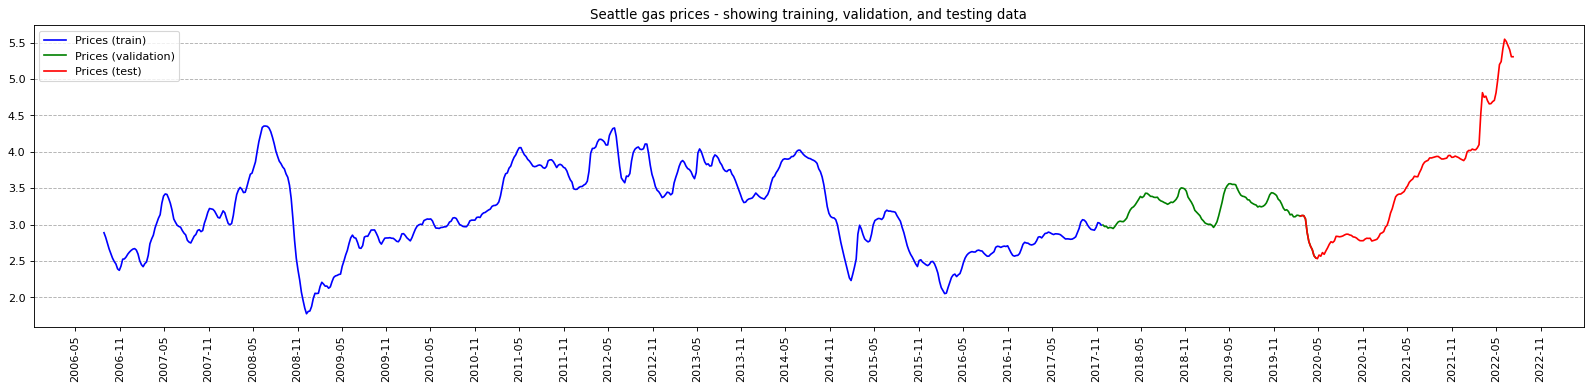

In [33]:
## Prepare data for plotting
data_date = features_targets.index.tolist()[timesteps:]
num_data_points = len(y)

to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)
to_plot_data_y_test = np.zeros(num_data_points)

to_plot_data_y_train[:train_length] = target_scaler.inverse_transform(target_train)
to_plot_data_y_val[train_length:train_length+val_length] = target_scaler.inverse_transform(target_val)
to_plot_data_y_test[-val_length:] = target_scaler.inverse_transform(target_test)

to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_test = np.where(to_plot_data_y_test == 0, None, to_plot_data_y_test)

## Plotting
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color='blue')
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color='green')
plt.plot(data_date, to_plot_data_y_test, label="Prices (test)", color='red')

# Format the x axis
locator = mdate.MonthLocator(interval=6)
fmt = mdate.DateFormatter('%Y-%m')
X = plt.gca().xaxis
X.set_major_locator(locator) # error
# Specify formatter
X.set_major_formatter(fmt)
plt.xticks(rotation='vertical')
# plt.xlim([data_date[0], data_date[-1]])

plt.title("Seattle gas prices - showing training, validation, and testing data")
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

## 4d. Build Torch Data Loaders

In [34]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_his_train_t = torch.Tensor(y_his_train)
y_his_val_t = torch.Tensor(y_his_val)
y_his_test_t = torch.Tensor(y_his_test)
target_train_t = torch.Tensor(target_train)
target_val_t = torch.Tensor(target_val)
target_test_t = torch.Tensor(target_test)

In [35]:
data_train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=batch_size)
data_val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=batch_size)
data_test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=batch_size)

# 6. Modeling

In [36]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [37]:
def nn_train(model, model_name, epochs, data_train_loader, data_val_loader, opt, scheduler, target_scaler, plot=True):
    
    loss = nn.MSELoss()

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=50, verbose=True, path=f'{model_name}.pt') 

    for i in range(epochs):
        mse_train = 0

        for batch_x, batch_y_h, batch_y in data_train_loader :

            batch_x = batch_x.to(device)  
            batch_y = batch_y.to(device)
            batch_y_h = batch_y_h.to(device)
            opt.zero_grad()
            
            if model_name == 'lstm':
                h, c = model.init_hidden_internal(batch_x.shape[0])
                y_pred, h, c = model(batch_x, batch_y_h, h, c)
            else:
                y_pred = model(batch_x, batch_y_h)

            y_pred = y_pred.squeeze(1)        
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()

        with torch.no_grad():
            mse_val = 0
            preds = []
            true = []
            for batch_x, batch_y_h, batch_y in data_val_loader:

                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                batch_y_h = batch_y_h.to(device)
                
                if model_name == 'lstm':
                    h, c = model.init_hidden_internal(batch_x.shape[0])
                    output, h, c = model(batch_x, batch_y_h, h, c)
                else:
                    output = model(batch_x, batch_y_h)

                output = output.squeeze(1)
                preds.append(output.detach().cpu().numpy())
                true.append(batch_y.detach().cpu().numpy())
                mse_val += loss(output, batch_y).item()*batch_x.shape[0]
                
        preds = np.concatenate(preds)
        true = np.concatenate(true)

        # Learning rate scheduler
        scheduler.step(mse_val/len(X_val_t))
        lr = opt.param_groups[0]['lr']

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(mse_val/len(X_val_t), model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, 
              "val: ", (mse_val/len(X_val_t))**0.5, 
              "LR: ", lr
             )
        if (plot == True) and (i % 10 == 0):
#             preds = preds*(target_train_max - target_train_min) + target_train_min
#             true = true*(target_train_max - target_train_min) + target_train_min
            preds = target_scaler.inverse_transform(preds)
            true = target_scaler.inverse_transform(true)
            mse = mean_squared_error(true, preds)
            mae = mean_absolute_error(true, preds)
            print("mse: ", mse, "mae: ", mae)
            plt.figure(figsize=(12, 6))
            plt.plot(preds, label='predicted')
            plt.plot(true, marker=".", markersize=10, color='black', linestyle = 'None', label='actual')
            plt.legend(loc="upper left")
            plt.title(f'Validation Results for Epoch {i}')
            plt.show()
    return

In [38]:
def nn_eval(model, model_name, data_test_loader, target_scaler):
    
    with torch.no_grad():
        mse_val = 0
        loss = nn.MSELoss()
        preds = []
        true = []
        for batch_x, batch_y_h, batch_y in data_test_loader:
            h, c = lstm.init_hidden_internal(batch_x.shape[0])
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_y_h = batch_y_h.to(device)
            
            if model_name == 'lstm':
                h, c = model.init_hidden_internal(batch_x.shape[0])
                output, h, c = model(batch_x, batch_y_h, h, c)
            else:
                output = model(batch_x, batch_y_h)
                
            output = output.squeeze(1)
            
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(torch.squeeze(output), batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    # De-normalize
    preds = target_scaler.inverse_transform(preds)
    true = target_scaler.inverse_transform(true)
    
    # Collect results
    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)
    r2 = r2_score(true, preds)
    pcc, _ = PCC(true, preds)  
    err = true - preds
    
    # Time series plot
    plt.figure(figsize=(12, 6))
    plt.plot(preds, label='preds')
    plt.plot(true, marker=".", markersize=10, color='black', linestyle = 'None', label='actual')
    plt.legend(loc="upper left")
    plt.title(f'Test Results for {model_name.upper()} Model', fontsize=15)
    plt.xlabel('Samples', fontsize=12)
    plt.ylabel('Seattle Gas Price', fontsize=12)
    plt.show()
    
    # Scatter Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.regplot(ax=ax, x=true, y=preds)
    ax.set_xlabel('True Values', fontsize=12)
    ax.set_ylabel('Predictions', fontsize=12)
    ax.set_title(f'Test Prediction Correlation \n R2 = {r2:.3f} \n PCC = {pcc:.3f}', fontsize=15)
    ax.set_aspect('equal', 'box')
    
    # Error Histogram
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.histplot(ax=ax, data=err, kde=True)
    ax.set_xlabel('Prediction Errors (U.S. $)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'Model Testing Prediction Errors \n MSE = {mse:.3f} \n MAE = {mae:.3f}', fontsize=15)
    
    return mse, mae, r2, pcc, preds, true

In [39]:
def nn_forecast(model, model_name, data, timesteps, n_timeseries, true, preds, x_scaler, y_his_scaler, target_scaler, plot_range=10):

    data = data.to_numpy()
    
    data_x_unseen = data[-timesteps:,:-1]
    y_hist_unseen = data[-timesteps:,-1]
    y_hist_unseen = np.expand_dims(y_hist_unseen, axis=1)
    
    data_x_unseen = x_scaler.transform(data_x_unseen)
    y_hist_unseen = y_his_scaler.transform(y_hist_unseen)
    
    x = torch.tensor(data_x_unseen).float().to(device).unsqueeze(0)
    y_hist = torch.tensor(y_hist_unseen).float().to(device).unsqueeze(0)

    model.eval()
    if model_name == 'lstm':
        h0, c0 = model.init_hidden_internal(x.shape[0])
        prediction, h, c = model(x, y_hist, h0, c0)
    else:
        prediction = model(x, y_hist)
        
    prediction = prediction.cpu().detach().numpy()

    # prepare plots

    to_plot_data_y_val = np.zeros(plot_range)
    to_plot_data_y_val_pred = np.zeros(plot_range)
    to_plot_data_y_test_pred = np.zeros(plot_range)

    to_plot_data_y_val[:plot_range-1] = true[-plot_range+1:]
    to_plot_data_y_val_pred[:plot_range-1] = preds[-plot_range+1:]

    to_plot_data_y_test_pred[plot_range-1] = target_scaler.inverse_transform(prediction)

    to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

    # plot
    plot_date_test = data_date[-plot_range+1:]
    next_week = plot_date_test[-1] + dt.timedelta(days=7)
    plot_date_test.append(next_week)

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color='black')
    plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10)
    plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next week", marker=".", markersize=20, color='red')
    plt.title("Predicted Seattle gas price of the next week")
    plt.grid(visible=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    print(f'{model_name.upper()} Predicted Seattle Gas Price of the next week: ${to_plot_data_y_test_pred[plot_range-1]:.2f}')
    
    return

## 6a. Time Series Model (Neural Prophet)

### Training

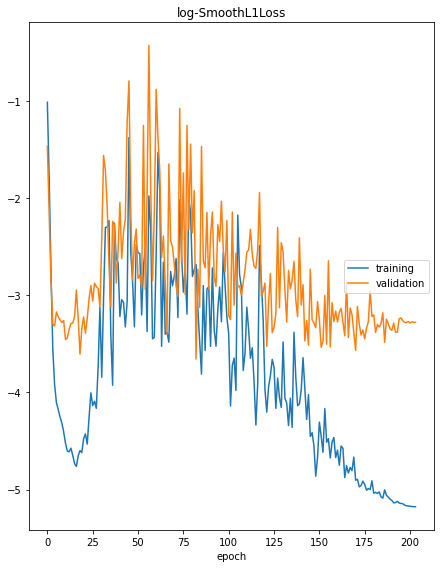

log-SmoothL1Loss
	training         	 (min:   -5.176, max:   -1.013, cur:   -5.176)
	validation       	 (min:   -3.656, max:   -0.428, cur:   -3.278)


In [40]:
data = seattle_gas_prices
df = data['data'].set_axis(['ds', 'y'], axis=1, inplace=False)

# https://rdrr.io/github/AlbertoAlmuinha/neuralprophet/man/neural_prophet.html
params = {
    # "seasonality_mode": "additive", 
    # "learning_rate": 0.1,
    # "n_changepoints": 40, # 48
    # "changepoints_range": 0.95, 
    # "trend_reg": 1,
    # "num_hidden_layers": 2,
    # "d_hidden": 64,
    # "yearly_seasonality": True, # True
    # "weekly_seasonality": False,
    # "daily_seasonality": False,
    # "loss_func": 'MSE',
    # "n_lags": 12,
    # "user_changepoints", 
}

model = NeuralProphet(**params)

df_train, df_test = model.split_df(df=df, freq="W", valid_p=0.15)

metrics =  model.fit(df_train, freq="W", validation_df=df_test, progress="plot")

In [41]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
203,0.005651,0.197422,0.259832,0.0,0.037719,0.574936,0.696533


### Evaluation

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.038  0.575  0.697


   SmoothL1Loss       MAE      RMSE
0      0.037719  0.574936  0.696533


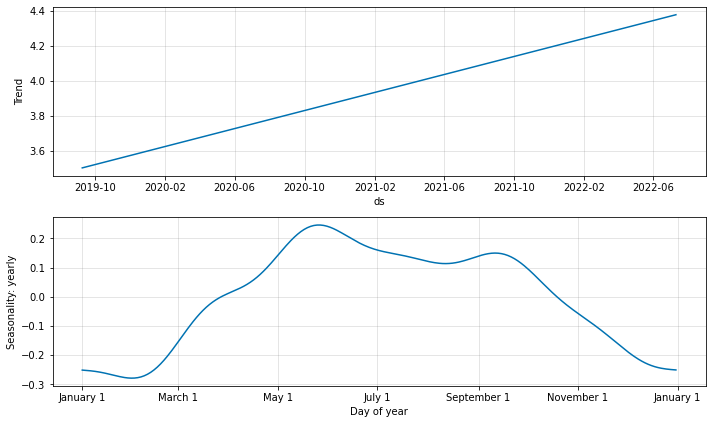

In [42]:
test_pred = model.predict(df_test)
test_components = model.plot_components(test_pred)

test_metrics = model.test(df_test)
print(test_metrics)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


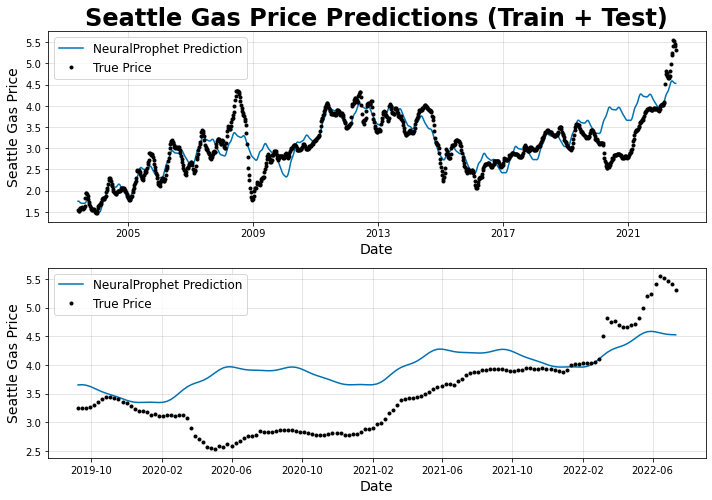

In [43]:
# fig, ax = plt.subplots(figsize=(10, 7))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=False)
model.plot(model.predict(df), ax=ax1)
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Seattle Gas Price', fontsize=14)
ax1.set_title("Seattle Gas Price Predictions (Train + Test)", fontsize=24, fontweight="bold")
ax1.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

# fig, ax = plt.subplots(figsize=(10, 7))
model.plot(test_pred, xlabel='Date', ylabel='Seattle Gas Price', ax=ax2)
ax2.set_xlabel('Date', fontsize=14)
ax2.set_ylabel('Seattle Gas Price', fontsize=14)
ax2.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

### Forecasting

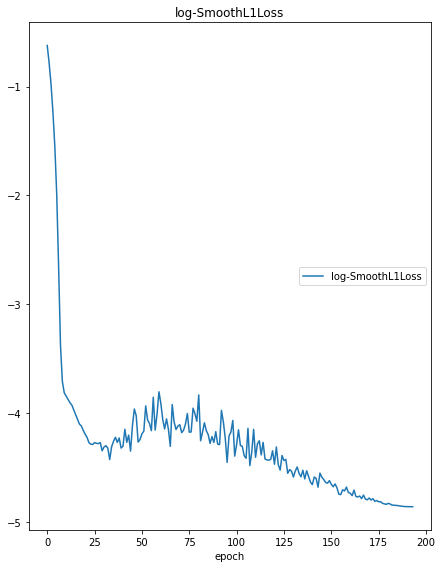

log-SmoothL1Loss
	log-SmoothL1Loss 	 (min:   -4.856, max:   -0.623, cur:   -4.856)


In [44]:
model2 = NeuralProphet(**params)
metrics_train2 = model2.fit(df=df, freq="W", progress="plot")

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


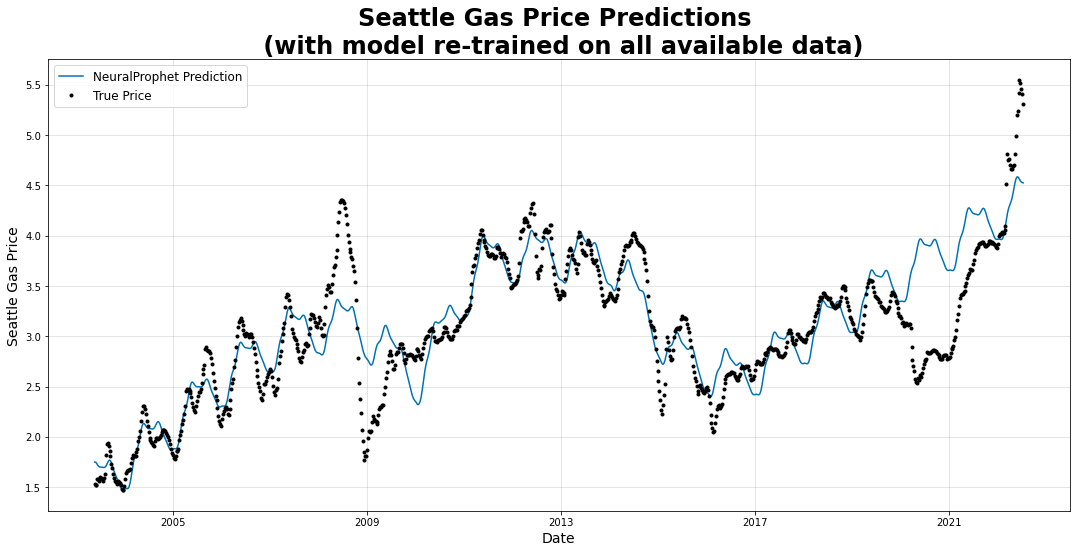

In [45]:
# fig = model.plot(model2.predict(df))
fig, ax = plt.subplots(figsize=(15, 7))
model.plot(model.predict(df), ax=ax)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Seattle Gas Price', fontsize=14)
ax.set_title("Seattle Gas Price Predictions \n (with model re-trained on all available data)", fontsize=24, fontweight="bold")
ax.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

In [46]:
future = model2.make_future_dataframe(df, periods=12, n_historic_predictions=96)
forecast = model2.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (py.warnings._showwarnmsg) - C:\Users\cpras\anaconda3\envs\GasPrice\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.148% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.148% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (py.warnings._showwarnmsg) - C:\Users\cpras\anaconda3\envs\GasPrice\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning: T

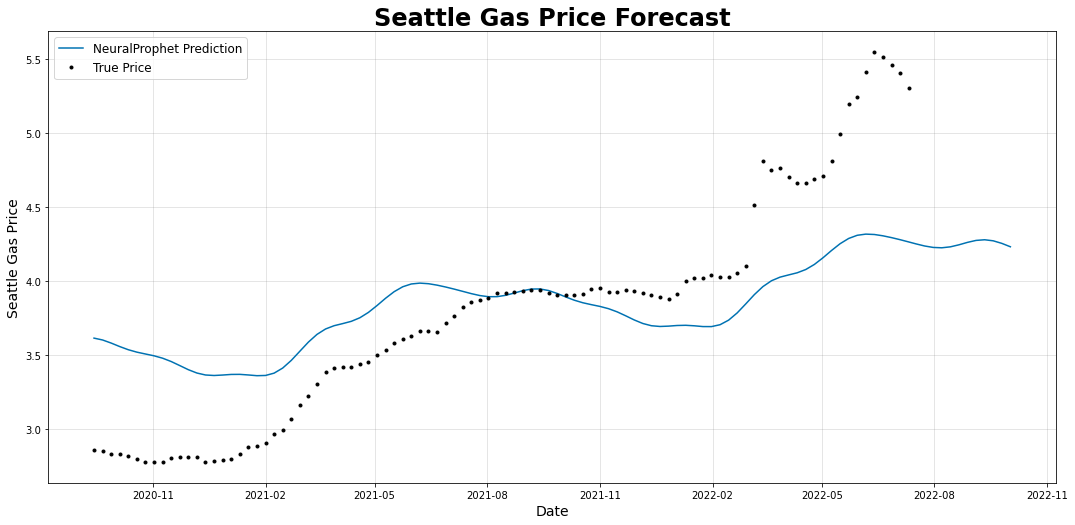

In [47]:
# fig = model2.plot(forecast)

fig, ax = plt.subplots(figsize=(15, 7))
model.plot(forecast, ax=ax)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Seattle Gas Price', fontsize=14)
ax.set_title("Seattle Gas Price Forecast", fontsize=24, fontweight="bold")
ax.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

## 6b. Neural Network (LSTM)

### Training

In [68]:
lstm = LSTM(num_classes=1, input_size=n_timeseries+1, hidden_size=64, num_layers=2, # hidden=64, layers=2
             seq_length=timesteps, device=device, dropout=0.2)
model_name = 'lstm'
lstm_opt = torch.optim.Adam(lstm.parameters(), lr=0.01)
lstm_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=lstm_opt, patience=15)

Validation loss decreased (inf --> 0.017168).  Saving model ...
Iter:  0 train:  0.24425201256447082 val:  0.131025386161836 LR:  0.01
mse:  0.114363365 mae:  0.29368532


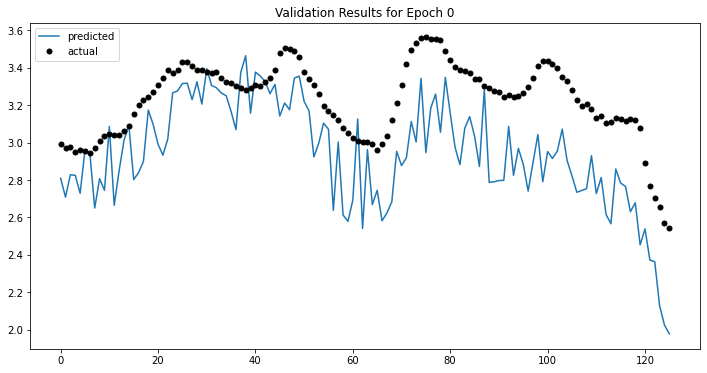

Validation loss decreased (0.017168 --> 0.012973).  Saving model ...
Iter:  1 train:  0.0881532653486048 val:  0.11389993675294921 LR:  0.01
Validation loss decreased (0.012973 --> 0.006676).  Saving model ...
Iter:  2 train:  0.06149401827770877 val:  0.08170879143784307 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  3 train:  0.05466940350751682 val:  0.09503874705408394 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  4 train:  0.04825770204542978 val:  0.14000031612794675 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  5 train:  0.04497984734877681 val:  0.09484827153346169 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  6 train:  0.043378639555749006 val:  0.0832658658501291 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  7 train:  0.04419707182533637 val:  0.0992015101834042 LR:  0.01
Validation loss decreased (0.006676 --> 0.005160).  Saving model ...
Iter:  8 train:  0.04087606799298603 val:  0.07183032736595406 LR:  0.01
Validation loss decreased (0.005160 

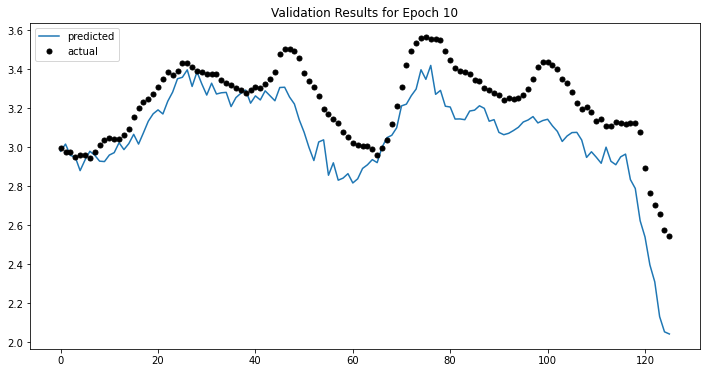

EarlyStopping counter: 2 out of 50
Iter:  11 train:  0.04637348288828519 val:  0.10424860608165848 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  12 train:  0.04127922949976935 val:  0.07535976446070361 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  13 train:  0.03378292044458587 val:  0.08887066111553708 LR:  0.01
Validation loss decreased (0.005123 --> 0.003776).  Saving model ...
Iter:  14 train:  0.03760811558108571 val:  0.06144949096034103 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  15 train:  0.03944821779338452 val:  0.09578118756652582 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  16 train:  0.04686529919913915 val:  0.09784053731555692 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  17 train:  0.03197125572162836 val:  0.08865402517956412 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  18 train:  0.03212687637974996 val:  0.06227493815975037 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  19 train:  0.030437084076216585 val:  0.076562606849

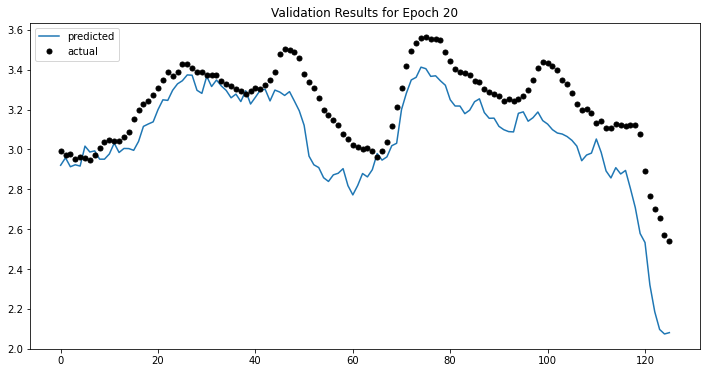

EarlyStopping counter: 7 out of 50
Iter:  21 train:  0.03404713983856926 val:  0.07462389407526425 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  22 train:  0.030005208095846208 val:  0.07662783717545107 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  23 train:  0.0317460639890852 val:  0.07967640041544331 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  24 train:  0.030796372545828253 val:  0.09150800009674842 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  25 train:  0.02701066492440137 val:  0.07726927583883621 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  26 train:  0.029113916356377115 val:  0.07755162063330859 LR:  0.01
Validation loss decreased (0.003776 --> 0.003343).  Saving model ...
Iter:  27 train:  0.03162201054796469 val:  0.05781476914725276 LR:  0.01
Validation loss decreased (0.003343 --> 0.002851).  Saving model ...
Iter:  28 train:  0.0299208106119107 val:  0.05339088911021213 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  29 train:  0.0

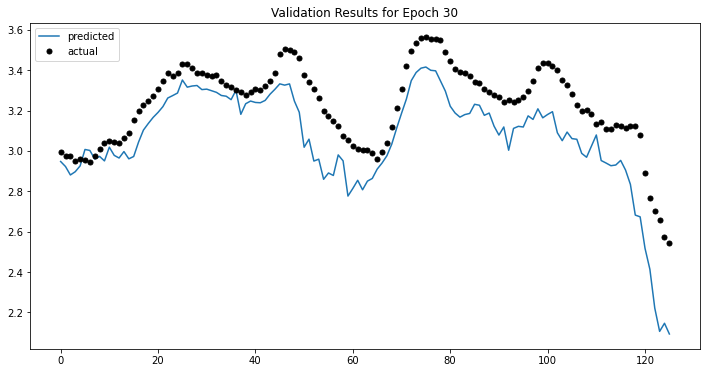

EarlyStopping counter: 3 out of 50
Iter:  31 train:  0.03359169996384626 val:  0.08564428934181638 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  32 train:  0.02938623444336197 val:  0.05643785691517446 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  33 train:  0.025533322429134416 val:  0.06406681728916302 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  34 train:  0.023843696320082538 val:  0.056042275332429996 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  35 train:  0.02766338306189052 val:  0.0969724544993246 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  36 train:  0.02904433740962362 val:  0.06818999129759588 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  37 train:  0.02841163634338035 val:  0.0670521144878935 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  38 train:  0.02461072939034084 val:  0.07282645412230387 LR:  0.01
Validation loss decreased (0.002851 --> 0.002726).  Saving model ...
Iter:  39 train:  0.02451895352145275 val:  0.05220765549

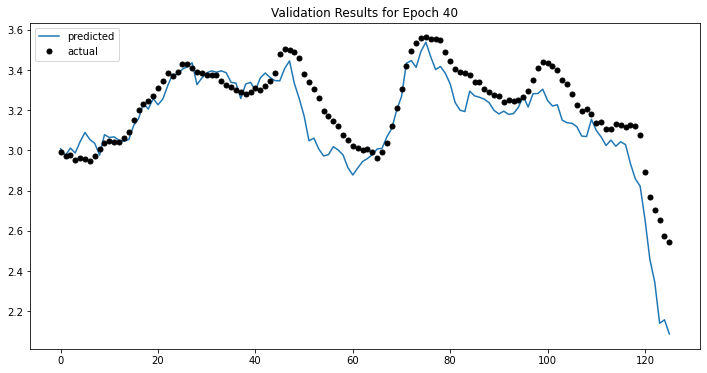

EarlyStopping counter: 2 out of 50
Iter:  41 train:  0.02515099941510013 val:  0.0610109013395725 LR:  0.01
Validation loss decreased (0.002726 --> 0.001885).  Saving model ...
Iter:  42 train:  0.023251623187610142 val:  0.0434135757767875 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  43 train:  0.023195406495511568 val:  0.05034841633997732 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  44 train:  0.021798396741787386 val:  0.05370285212773834 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  45 train:  0.023296446823771105 val:  0.061015211479664364 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  46 train:  0.02306957113962949 val:  0.048916074662066746 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  47 train:  0.035128100363843257 val:  0.0722623060369274 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  48 train:  0.03026646826071105 val:  0.04831222938409892 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  49 train:  0.030676039499227193 val:  0.04679431

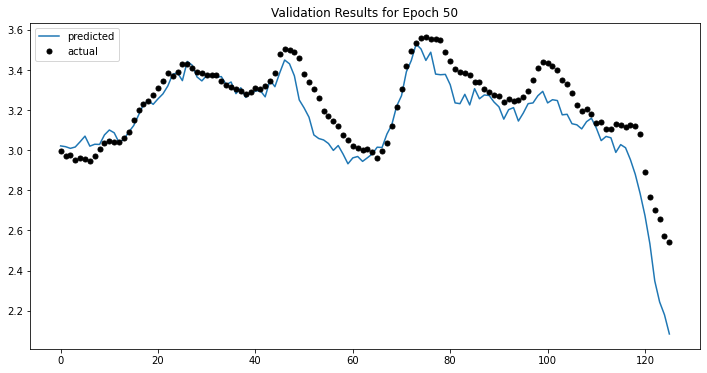

EarlyStopping counter: 9 out of 50
Iter:  51 train:  0.02655839862606853 val:  0.052018420712530815 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  52 train:  0.025678049746092516 val:  0.05222126547371589 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  53 train:  0.02393054289779623 val:  0.04561323599050723 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  54 train:  0.025867813930592058 val:  0.054764165819122884 LR:  0.01
Validation loss decreased (0.001885 --> 0.001762).  Saving model ...
Iter:  55 train:  0.022133212264541683 val:  0.041971818827834274 LR:  0.01
Validation loss decreased (0.001762 --> 0.001335).  Saving model ...
Iter:  56 train:  0.022491146320421467 val:  0.03654294106428357 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  57 train:  0.022961081186776817 val:  0.041890624658789406 LR:  0.01
Validation loss decreased (0.001335 --> 0.001257).  Saving model ...
Iter:  58 train:  0.02163126368204133 val:  0.035458712175278226 LR:  0.01
EarlyStopping

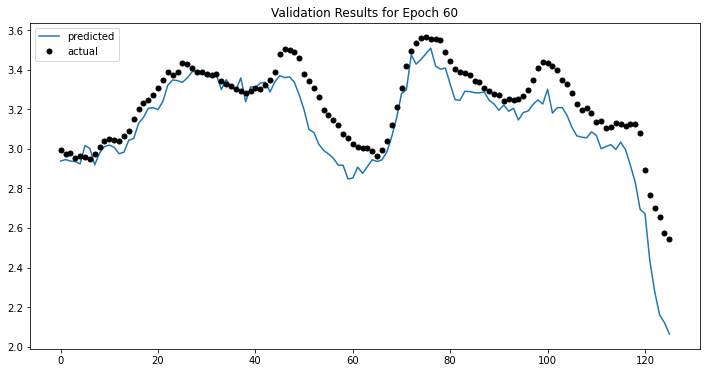

EarlyStopping counter: 3 out of 50
Iter:  61 train:  0.021426376967323954 val:  0.04983033745740706 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  62 train:  0.020809557404212958 val:  0.038422292535347 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  63 train:  0.02352757236928577 val:  0.04692944135417407 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  64 train:  0.022736699184484968 val:  0.038248486310533916 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  65 train:  0.025858945056232936 val:  0.0406736091376793 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  66 train:  0.028931262516609227 val:  0.04820722297248386 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  67 train:  0.020024376456033534 val:  0.04257968185405928 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  68 train:  0.020476668372933892 val:  0.03818287843529682 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  69 train:  0.02720310642678002 val:  0.04785378822894043 LR:  0.01
EarlyStoppin

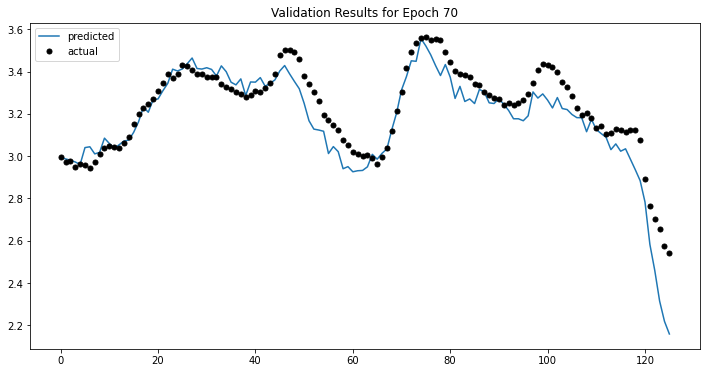

EarlyStopping counter: 13 out of 50
Iter:  71 train:  0.02173914607426707 val:  0.05755100607043599 LR:  0.01
EarlyStopping counter: 14 out of 50
Iter:  72 train:  0.020755509569590658 val:  0.04947770158820306 LR:  0.01
EarlyStopping counter: 15 out of 50
Iter:  73 train:  0.0214491867701393 val:  0.03630586389311767 LR:  0.01
EarlyStopping counter: 16 out of 50
Iter:  74 train:  0.021132422773992784 val:  0.03723394374122698 LR:  0.001
EarlyStopping counter: 17 out of 50
Iter:  75 train:  0.016305581461997024 val:  0.043329163199099484 LR:  0.001
EarlyStopping counter: 18 out of 50
Iter:  76 train:  0.015355098758864573 val:  0.045461396328361804 LR:  0.001
EarlyStopping counter: 19 out of 50
Iter:  77 train:  0.0141213314942617 val:  0.045808899375083076 LR:  0.001
EarlyStopping counter: 20 out of 50
Iter:  78 train:  0.015013796144738105 val:  0.04524716964549489 LR:  0.001
EarlyStopping counter: 21 out of 50
Iter:  79 train:  0.014806503900507783 val:  0.04254156437008389 LR:  0.0

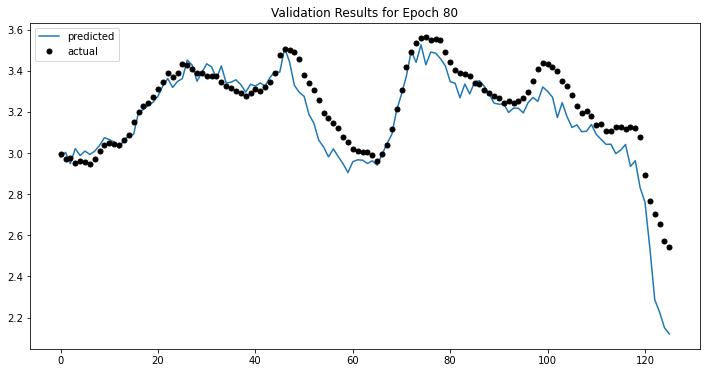

EarlyStopping counter: 23 out of 50
Iter:  81 train:  0.014993771501969603 val:  0.04243388190730866 LR:  0.001
EarlyStopping counter: 24 out of 50
Iter:  82 train:  0.014193219211139889 val:  0.040577581225706524 LR:  0.001
EarlyStopping counter: 25 out of 50
Iter:  83 train:  0.01514900807166217 val:  0.041124694689870775 LR:  0.001
EarlyStopping counter: 26 out of 50
Iter:  84 train:  0.01504588499781698 val:  0.04204113572769868 LR:  0.001
EarlyStopping counter: 27 out of 50
Iter:  85 train:  0.014813710024937537 val:  0.041472810606452935 LR:  0.001
EarlyStopping counter: 28 out of 50
Iter:  86 train:  0.015003367956517159 val:  0.04060188960462556 LR:  0.001
EarlyStopping counter: 29 out of 50
Iter:  87 train:  0.014588513331800824 val:  0.041277920943919744 LR:  0.001
EarlyStopping counter: 30 out of 50
Iter:  88 train:  0.014263786185176491 val:  0.04215275271216707 LR:  0.001
EarlyStopping counter: 31 out of 50
Iter:  89 train:  0.014195034206171388 val:  0.045725254779713176 

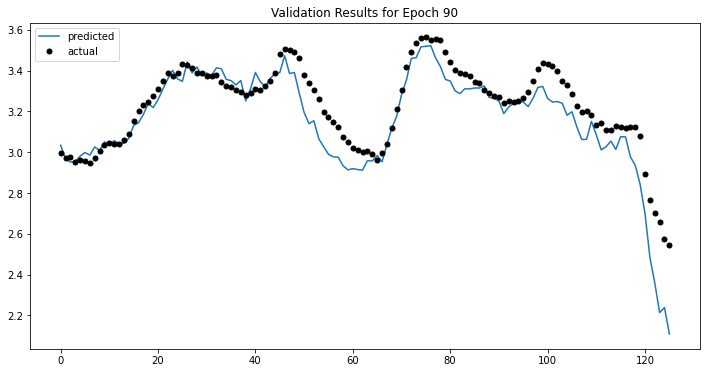

EarlyStopping counter: 33 out of 50
Iter:  91 train:  0.014353563087700645 val:  0.04150789946892412 LR:  0.0001
EarlyStopping counter: 34 out of 50
Iter:  92 train:  0.014410694475757156 val:  0.04132813148971072 LR:  0.0001
EarlyStopping counter: 35 out of 50
Iter:  93 train:  0.013955581758071784 val:  0.044956126591507745 LR:  0.0001
EarlyStopping counter: 36 out of 50
Iter:  94 train:  0.01386790717423133 val:  0.0456312120351852 LR:  0.0001
EarlyStopping counter: 37 out of 50
Iter:  95 train:  0.013648817314199974 val:  0.04367214239824047 LR:  0.0001
EarlyStopping counter: 38 out of 50
Iter:  96 train:  0.013774741425931769 val:  0.04373739838664573 LR:  0.0001
EarlyStopping counter: 39 out of 50
Iter:  97 train:  0.013051115817427695 val:  0.04507386924748831 LR:  0.0001
EarlyStopping counter: 40 out of 50
Iter:  98 train:  0.013822698829728877 val:  0.04297552616117219 LR:  0.0001
EarlyStopping counter: 41 out of 50
Iter:  99 train:  0.01359292321433217 val:  0.040675814708075

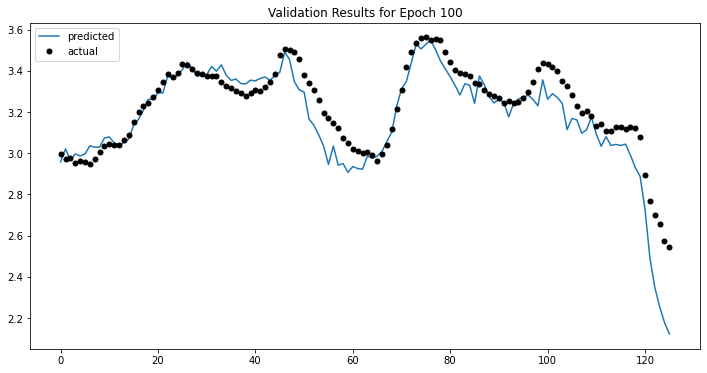

EarlyStopping counter: 43 out of 50
Iter:  101 train:  0.013521639084262274 val:  0.04170814305183488 LR:  0.0001
EarlyStopping counter: 44 out of 50
Iter:  102 train:  0.014109872576660427 val:  0.04303298555234985 LR:  0.0001
EarlyStopping counter: 45 out of 50
Iter:  103 train:  0.013515781735588593 val:  0.04346646489614972 LR:  0.0001
EarlyStopping counter: 46 out of 50
Iter:  104 train:  0.014065743065750817 val:  0.042335695375771816 LR:  0.0001
EarlyStopping counter: 47 out of 50
Iter:  105 train:  0.01351656643544495 val:  0.04348755067651628 LR:  0.0001
EarlyStopping counter: 48 out of 50
Iter:  106 train:  0.013004518509623272 val:  0.042540518272827836 LR:  1e-05
EarlyStopping counter: 49 out of 50
Iter:  107 train:  0.013425376419795059 val:  0.04402021841553855 LR:  1e-05
EarlyStopping counter: 50 out of 50
Early stopping


In [50]:
nn_train(model=lstm, 
         model_name=model_name, 
         epochs=max_epochs, 
         data_train_loader=data_train_loader, 
         data_val_loader=data_val_loader, 
         opt=lstm_opt, 
         scheduler=lstm_scheduler,
         target_scaler=target_scaler,
         plot=True)

### Evaluation

In [51]:
lstm.load_state_dict(torch.load(f"{model_name}.pt"))

<All keys matched successfully>

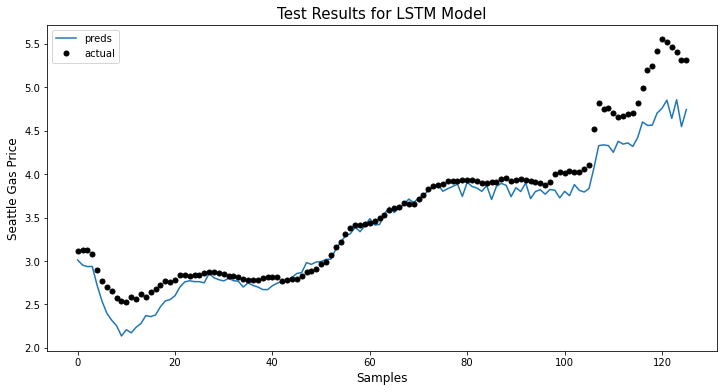

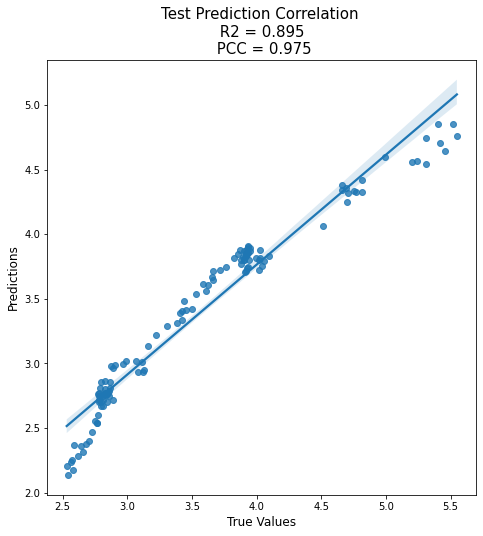

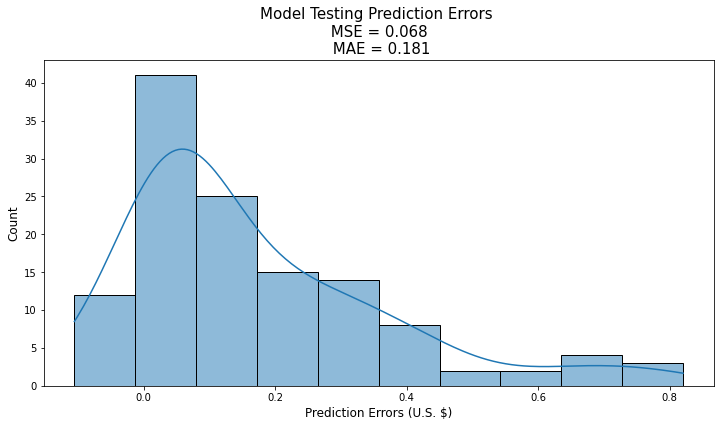

In [52]:
lstm_mse, lstm_mae, lstm_r2, lstm_pcc, lstm_preds, lstm_true = nn_eval(model=lstm, 
                                                                       model_name='lstm', 
                                                                       data_test_loader=data_test_loader, 
                                                                       target_scaler=target_scaler)

### Forecasting

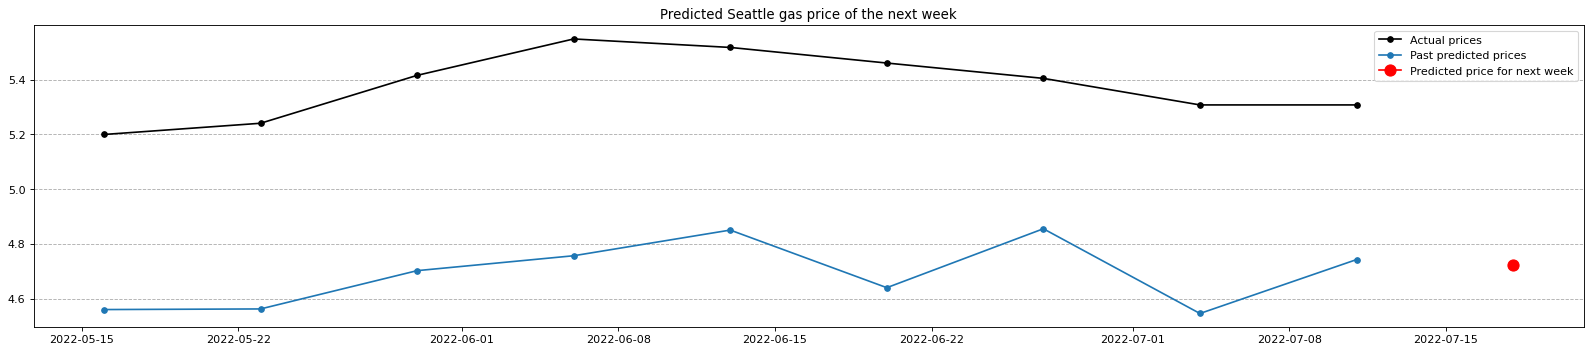

LSTM Predicted Seattle Gas Price of the next week: $4.72


In [53]:
nn_forecast(model = lstm,
            model_name = 'lstm', 
            data = features_targets, 
            timesteps = timesteps, 
            n_timeseries = n_timeseries, 
            true = lstm_true, 
            preds = lstm_preds,
            x_scaler = x_scaler, 
            y_his_scaler = y_his_scaler, 
            target_scaler = target_scaler, 
            plot_range=10
           )

## 6c. Attentioned-Based Neural Network (DA-RNN)

### Training

In [69]:
darnn = DARNN(N=X_train.shape[2], M=64, P=16, T=X_train.shape[1], device=device).to(device) # 1) M=64, N=16; 2) M=32, N=32
model_name = 'darnn'
darnn_opt = torch.optim.Adam(darnn.parameters(), lr=0.01)
darnn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=darnn_opt, patience=15)

Validation loss decreased (inf --> 0.007985).  Saving model ...
Iter:  0 train:  0.2604444249217721 val:  0.0893573069261367 LR:  0.01
mse:  0.053190753 mae:  0.19624922


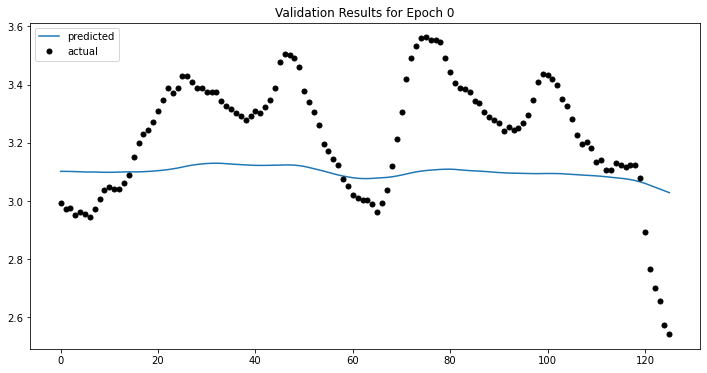

EarlyStopping counter: 1 out of 50
Iter:  1 train:  0.14047852139979267 val:  0.16744390569879333 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  2 train:  0.07151876508618715 val:  0.14060652255510872 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  3 train:  0.06093483756907824 val:  0.11260137397580598 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  4 train:  0.05369703693380194 val:  0.13030339755736714 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  5 train:  0.05072959302053463 val:  0.12485550069345962 LR:  0.01
Validation loss decreased (0.007985 --> 0.005407).  Saving model ...
Iter:  6 train:  0.03885149878719076 val:  0.07353071301800643 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  7 train:  0.03940098431494321 val:  0.0817162524234892 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  8 train:  0.03440089151366093 val:  0.08571673817725618 LR:  0.01
Validation loss decreased (0.005407 --> 0.004622).  Saving model ...
Iter:  9 train:  0.030429914203738

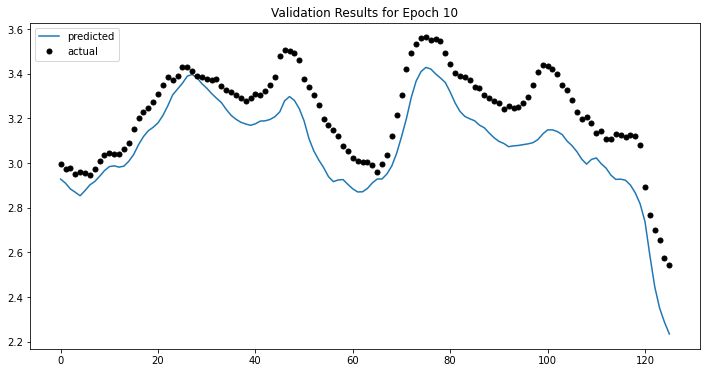

Validation loss decreased (0.004177 --> 0.001521).  Saving model ...
Iter:  11 train:  0.024304657917547177 val:  0.038993998832831986 LR:  0.01
Validation loss decreased (0.001521 --> 0.001103).  Saving model ...
Iter:  12 train:  0.020870523732667172 val:  0.03320491028085758 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  13 train:  0.02092647651722244 val:  0.05759979045182947 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  14 train:  0.022679713637085604 val:  0.03903647136985669 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  15 train:  0.020084634064123377 val:  0.04947110616248648 LR:  0.01
Validation loss decreased (0.001103 --> 0.000812).  Saving model ...
Iter:  16 train:  0.019483460870063748 val:  0.028493039161920024 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  17 train:  0.019410967638479784 val:  0.04540413955653054 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  18 train:  0.01733334359999614 val:  0.028770233781142414 LR:  0.01
EarlyStopping cou

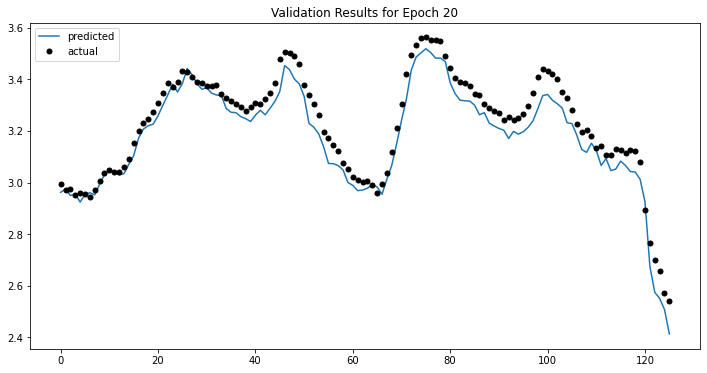

Validation loss decreased (0.000532 --> 0.000374).  Saving model ...
Iter:  21 train:  0.01714361600883739 val:  0.01934446138902725 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  22 train:  0.016030969746893657 val:  0.04331682799328154 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  23 train:  0.018366677333862144 val:  0.02713847298875186 LR:  0.01
Validation loss decreased (0.000374 --> 0.000184).  Saving model ...
Iter:  24 train:  0.016369008164466372 val:  0.013573046827988914 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  25 train:  0.017392730822056363 val:  0.025216939607123973 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  26 train:  0.01711425578564617 val:  0.03218866850764249 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  27 train:  0.01856500302596982 val:  0.039788872701755344 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  28 train:  0.015829063231747778 val:  0.019222823618128004 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  29 train:

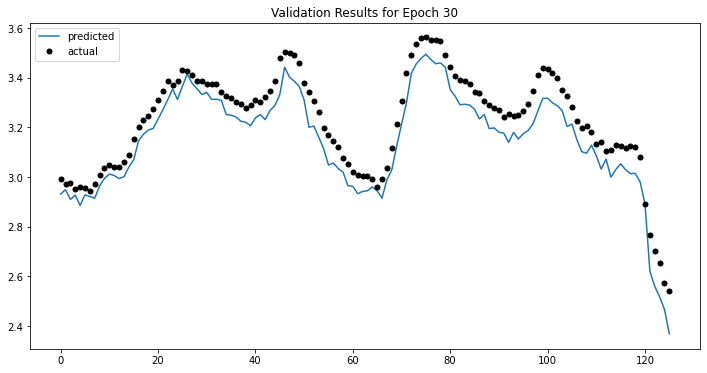

EarlyStopping counter: 7 out of 50
Iter:  31 train:  0.01747573567830063 val:  0.025823435473090482 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  32 train:  0.015243530095562643 val:  0.015760659016946635 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  33 train:  0.01509741523424503 val:  0.01550086420910953 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  34 train:  0.014898475855287445 val:  0.017857628171241823 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  35 train:  0.019056447741194693 val:  0.01678603992387211 LR:  0.01
Validation loss decreased (0.000184 --> 0.000157).  Saving model ...
Iter:  36 train:  0.01715824074480926 val:  0.012518926637074422 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  37 train:  0.018890417152995196 val:  0.022949166593360316 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  38 train:  0.015181813024667798 val:  0.020655896001531848 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  39 train:  0.016613963701619966 val:  0

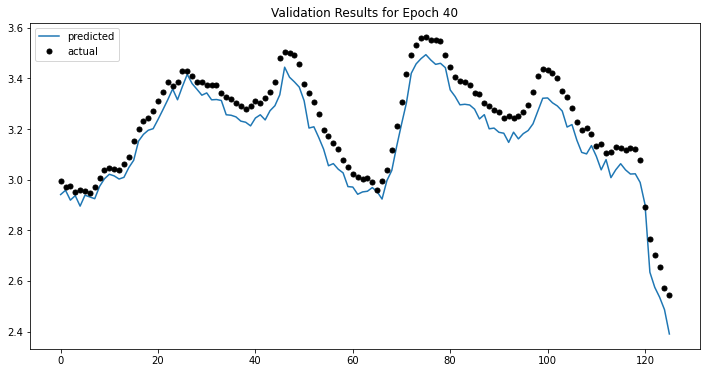

EarlyStopping counter: 5 out of 50
Iter:  41 train:  0.015207075794654124 val:  0.024027078024159532 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  42 train:  0.014181847537043756 val:  0.017822753782817773 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  43 train:  0.022886400050392712 val:  0.027099849940426468 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  44 train:  0.019447576774952253 val:  0.028815465119966504 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  45 train:  0.015151393455848169 val:  0.017941096038281357 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  46 train:  0.014285683095597402 val:  0.02464387976166257 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  47 train:  0.015281273301106258 val:  0.015760733335598007 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  48 train:  0.015776642914654863 val:  0.016133358116534595 LR:  0.01
EarlyStopping counter: 13 out of 50
Iter:  49 train:  0.018969838026056084 val:  0.013501164308212313 LR:  0.0

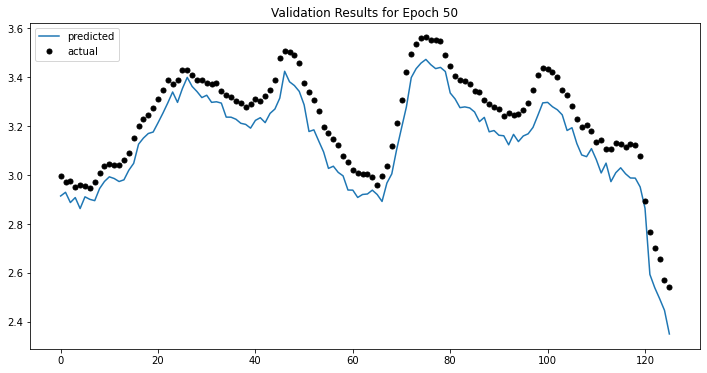

EarlyStopping counter: 15 out of 50
Iter:  51 train:  0.018454242849673258 val:  0.033464312974129634 LR:  0.01
EarlyStopping counter: 16 out of 50
Iter:  52 train:  0.016672543461229438 val:  0.025016286499669384 LR:  0.001
EarlyStopping counter: 17 out of 50
Iter:  53 train:  0.013400503341739782 val:  0.021059316320120536 LR:  0.001
EarlyStopping counter: 18 out of 50
Iter:  54 train:  0.013085067013198363 val:  0.020198618543637095 LR:  0.001
EarlyStopping counter: 19 out of 50
Iter:  55 train:  0.013137109176476267 val:  0.021400927749975228 LR:  0.001
EarlyStopping counter: 20 out of 50
Iter:  56 train:  0.013440681001106168 val:  0.019010205753314136 LR:  0.001
EarlyStopping counter: 21 out of 50
Iter:  57 train:  0.013485316310285905 val:  0.02296815730158673 LR:  0.001
EarlyStopping counter: 22 out of 50
Iter:  58 train:  0.013474457555256659 val:  0.019330670375378757 LR:  0.001
EarlyStopping counter: 23 out of 50
Iter:  59 train:  0.013179140210393209 val:  0.020793436209658

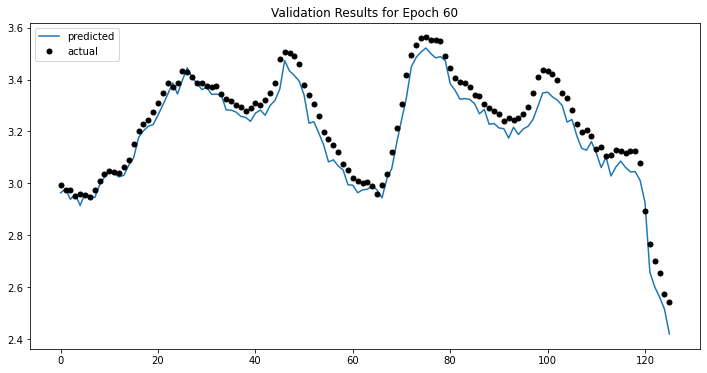

EarlyStopping counter: 25 out of 50
Iter:  61 train:  0.013054996418705427 val:  0.021547134732978517 LR:  0.001
EarlyStopping counter: 26 out of 50
Iter:  62 train:  0.013127284254930338 val:  0.019273290566095336 LR:  0.001
EarlyStopping counter: 27 out of 50
Iter:  63 train:  0.013209478293882557 val:  0.021202232492687864 LR:  0.001
EarlyStopping counter: 28 out of 50
Iter:  64 train:  0.013317667405166619 val:  0.020381598504235782 LR:  0.001
EarlyStopping counter: 29 out of 50
Iter:  65 train:  0.013705216148363088 val:  0.015426445584109426 LR:  0.001
EarlyStopping counter: 30 out of 50
Iter:  66 train:  0.013914801465197937 val:  0.017280350711051773 LR:  0.001
EarlyStopping counter: 31 out of 50
Iter:  67 train:  0.013173504416018793 val:  0.018858932119015463 LR:  0.001
EarlyStopping counter: 32 out of 50
Iter:  68 train:  0.01310894987307492 val:  0.022561678229600944 LR:  0.0001
EarlyStopping counter: 33 out of 50
Iter:  69 train:  0.012841258198109629 val:  0.0196744159572

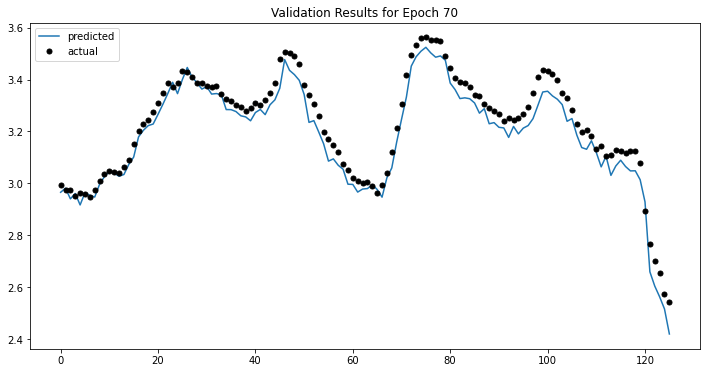

EarlyStopping counter: 35 out of 50
Iter:  71 train:  0.012866100445456491 val:  0.02070393056903848 LR:  0.0001
EarlyStopping counter: 36 out of 50
Iter:  72 train:  0.012897299367737765 val:  0.020195671084039787 LR:  0.0001
EarlyStopping counter: 37 out of 50
Iter:  73 train:  0.012868255360610878 val:  0.020633804489197067 LR:  0.0001
EarlyStopping counter: 38 out of 50
Iter:  74 train:  0.012847583696089312 val:  0.01990144260998396 LR:  0.0001
EarlyStopping counter: 39 out of 50
Iter:  75 train:  0.012852983077511574 val:  0.020663311428944807 LR:  0.0001
EarlyStopping counter: 40 out of 50
Iter:  76 train:  0.012864844073486231 val:  0.02027341047720446 LR:  0.0001
EarlyStopping counter: 41 out of 50
Iter:  77 train:  0.012853178700714698 val:  0.019868294660135764 LR:  0.0001
EarlyStopping counter: 42 out of 50
Iter:  78 train:  0.012864532831871351 val:  0.020659754356788865 LR:  0.0001
EarlyStopping counter: 43 out of 50
Iter:  79 train:  0.012873166659476356 val:  0.02047093

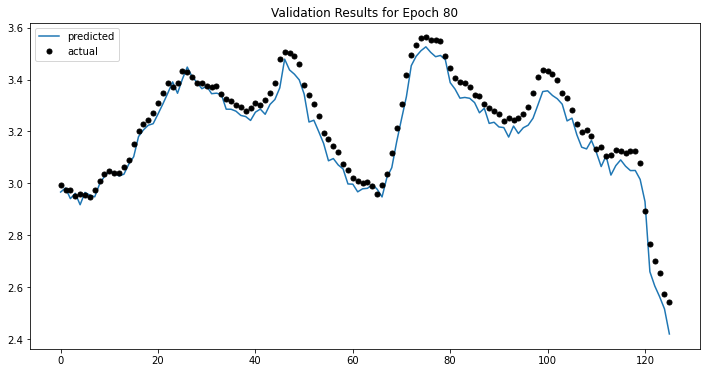

EarlyStopping counter: 45 out of 50
Iter:  81 train:  0.012832952367755926 val:  0.02077718640040915 LR:  0.0001
EarlyStopping counter: 46 out of 50
Iter:  82 train:  0.01284935177280792 val:  0.020006322098131895 LR:  0.0001
EarlyStopping counter: 47 out of 50
Iter:  83 train:  0.012834919079836023 val:  0.021041648396647798 LR:  0.0001
EarlyStopping counter: 48 out of 50
Iter:  84 train:  0.012891162691218257 val:  0.020251601422824547 LR:  1e-05
EarlyStopping counter: 49 out of 50
Iter:  85 train:  0.012819664043395273 val:  0.02030590355306156 LR:  1e-05
EarlyStopping counter: 50 out of 50
Early stopping


In [62]:
nn_train(model=darnn, 
         model_name=model_name, 
         epochs=max_epochs, 
         data_train_loader=data_train_loader, 
         data_val_loader=data_val_loader, 
         opt=darnn_opt, 
         scheduler=darnn_scheduler,
         target_scaler=target_scaler,
         plot=True)

### Evaluation

In [63]:
darnn.load_state_dict(torch.load(f"{model_name}.pt"))

<All keys matched successfully>

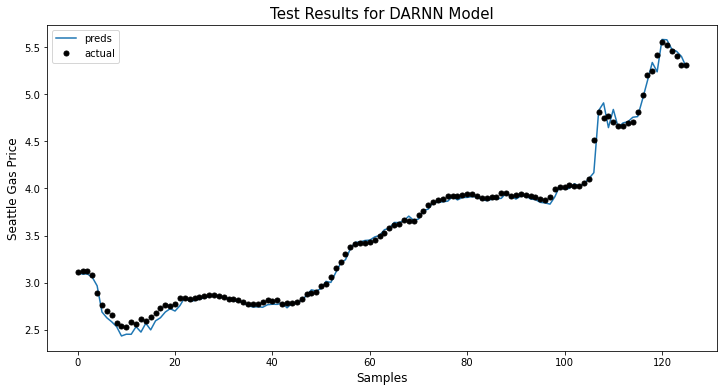

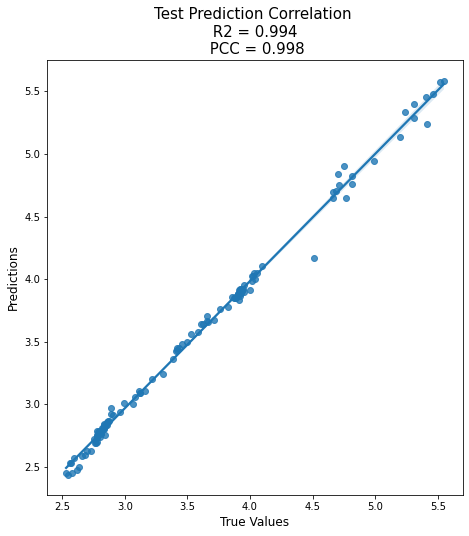

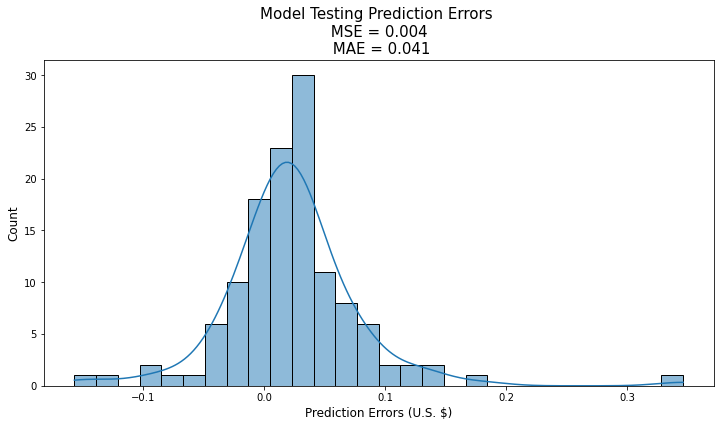

In [64]:
darnn_mse, darnn_mae, darnn_r2, darnn_pcc, darnn_preds, darnn_true = nn_eval(model=darnn, 
                                                                             model_name='darnn', 
                                                                             data_test_loader=data_test_loader, 
                                                                             target_scaler=target_scaler)

### Forecasting

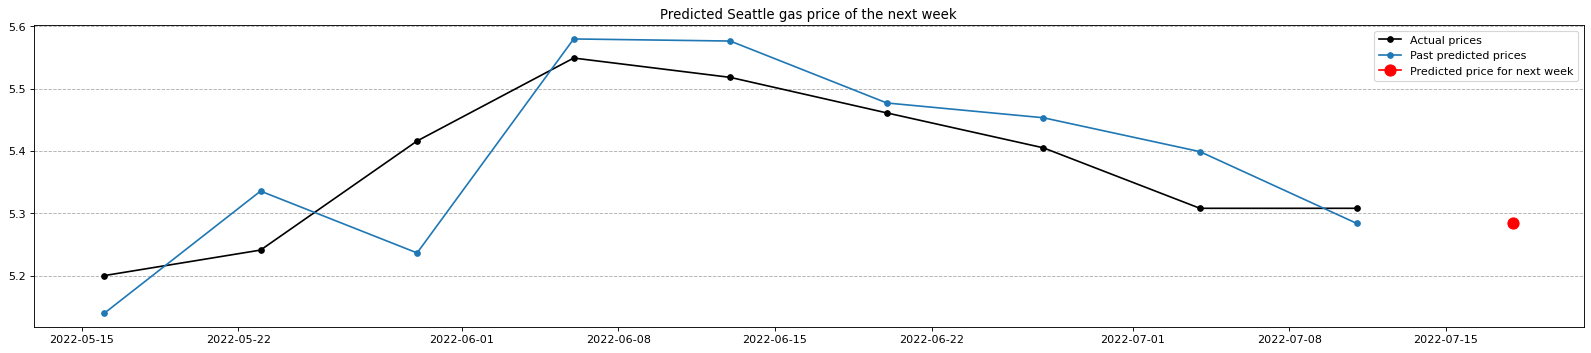

DARNN Predicted Seattle Gas Price of the next week: $5.28


In [65]:
nn_forecast(model = darnn,
            model_name = 'darnn', 
            data = features_targets, 
            timesteps = timesteps, 
            n_timeseries = n_timeseries, 
            true = darnn_true, 
            preds = darnn_preds,
            x_scaler = x_scaler, 
            y_his_scaler = y_his_scaler, 
            target_scaler = target_scaler, 
            plot_range=10
           )

# 8. Model Comparison